Config

In [1]:
class Config:
    model_path = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-small"
    downsample = 0.45
    truncation = True
    padding = False  #'max_length'
    max_length = 1024
    freeze_layers = 0

    target_cols = [
        "B-EMAIL",
        "B-ID_NUM",
        "B-NAME_STUDENT",
        "B-PHONE_NUM",
        "B-STREET_ADDRESS",
        "B-URL_PERSONAL",
        "B-USERNAME",
        "I-ID_NUM",
        "I-NAME_STUDENT",
        "I-PHONE_NUM",
        "I-STREET_ADDRESS",
        "I-URL_PERSONAL",
        "O",
    ]

In [2]:
import json, argparse, torch, sys, random, gc, os
import numpy as np
import pandas as pd
import functools
from itertools import chain
from functools import partial
from pathlib import Path
import ctypes

# Transformer
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    DebertaV2Config,
    DebertaV2ForTokenClassification,
)
from datasets import Dataset, features
from typing import Iterable, Any, Callable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from seqeval.metrics import recall_score, precision_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Seed the same seed to all 
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

SEED = 42
seed_everything(SEED)


libc = ctypes.CDLL("libc.so.6")
def clear_memory():
    libc.malloc_trim(0)
    torch.cuda.empty_cache()
    gc.collect()

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {DEVICE}")

Device: cuda


Pre Processeing

In [6]:
def load_data():
    # Load training data
    train_data = pd.read_json("/kaggle/input/pii-detection-removal-from-educational-data/train.json")
    print(f"kaggle train data = {len(train_data)}") # 6807
    # more_data = pd.read_json("/kaggle/input/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json")
    # print(f"more data = {len(more_data)}")
    # pii_dataset_fixed = pd.read_json("/kaggle/input/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json")
    # print(f"pii_dataset_fixed = {len(pii_dataset_fixed)}")

    # Combine to a single df
    # df = pd.concat([train_data, more_data, pii_dataset_fixed])
    # df = train_data
    df['document'] = [i for i in range(len(df))] # Update the document id
    df.reset_index(drop=True, inplace=True)
     # Get all the unique labels 
    all_labels = sorted(np.unique(functools.reduce(lambda a, b: list(np.unique(a+b)),
                                                  df['labels'].tolist())))
    print(f"all_labels = {all_labels}")
    # Create indexes for labels
    label2id = {label:index for index,label in enumerate(all_labels)}
    id2label = {index:label for index,label in enumerate(all_labels)}

    return df, all_labels, label2id, id2label


# Eencode labels to columns
def encode_labels(df: pd.DataFrame):
    total = len(df)
    df["unique_labels"] = df["labels"].apply(lambda labels: 
                                            list(set([label.split('-')[1] for label in labels if label != 'O'])))
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df['unique_labels'])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    df = pd.concat([df, one_hot_df], axis=1)
    # add 'POS' column that don't have 
    df['others'] = df['unique_labels'].apply(lambda x: 1 if len(x) == 0 else 0)
    label_classes = list(mlb.classes_) + ['others']
    for col in label_classes:
        subtotal = df[col].sum()
        percent = subtotal/total * 100
        print(f'{col}: {subtotal}  ({percent:.1f}%)')
    return df, label_classes

In [8]:
df, all_labels, label2id, id2label = load_data()
df_labels, label_classes = encode_labels(df.copy())
# df_labels.to_csv("df_labels.csv", encoding="utf-8")
# display(df_labels.tail(10))

kaggle train data = 6807
all_labels = ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']
EMAIL: 5661  (42.8%)
ID_NUM: 1865  (14.1%)
NAME_STUDENT: 6834  (51.6%)
PHONE_NUM: 4214  (31.8%)
STREET_ADDRESS: 5116  (38.6%)
URL_PERSONAL: 2546  (19.2%)
USERNAME: 2513  (19.0%)
others: 5872  (44.3%)


In [9]:
tokenizer = AutoTokenizer.from_pretrained(Config.model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
def split_df_by_sampling(df: pd.DataFrame, n_samples: int):
    # Get the sample df
    samples_df = df.sample(n=n_samples, random_state=SEED)
    # The remaining df
    cond = df["document"].isin(samples_df["document"])
    others_df = df.drop(df[cond].index, inplace=False)
    return samples_df, others_df


def downsample_df(df: pd.DataFrame):
    """Split the df into training and valid dataset"""
    df["is_labels"] = df["labels"].apply(
        lambda labels: any(label != "O" for label in labels)
    )

    # One or more labels are not 'O'
    true_labels = df[df["is_labels"]]
    # all labels are 'O'
    false_labels = df[~df["is_labels"]]

    # Reset index to two df
    true_labels = true_labels.reset_index(drop=True, inplace=False)
    false_labels = false_labels.reset_index(drop=True, inplace=False)
    print(f"Number of true_labels = {len(true_labels)}")
    print(f"Number of false_labels = {len(false_labels)}")

    # Get 300 as valid dataset
    n_samples = len(true_labels) - 150

    # Sample true labels
    true_samples, true_others = split_df_by_sampling(true_labels, n_samples)
    print(f"true_samples = {len(true_samples)} true_others = {len(true_others)}")
    n_samples = len(false_labels) - 150
    # Sample false labels
    false_samples, false_others = split_df_by_sampling(false_labels, n_samples)
    print(f"false_samples = {len(false_samples)} false_others = {len(false_others)}")
    # Training ds = P * true_labels + P * false_labels
    train_df = pd.concat([true_samples, false_samples])
    # Valid ds = (1-P) * true_labels + (1-P) * false_labels
    valid_df = pd.concat([true_others, false_others])
    return train_df, valid_df

In [15]:
# Split 'df' into training and valid dataset (300) based on whether the row is all 'O' or not. 
train_df, valid_df = downsample_df(df.copy())
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
print(f"Number of train_df = {len(train_df)}")
print(f"Number of valid_df = {len(valid_df)}")
clear_memory()

Number of true_labels = 7369
Number of false_labels = 5872
true_samples = 7219 true_others = 150
false_samples = 5722 false_others = 150
Number of train_df = 12941
Number of valid_df = 300


In [12]:
# Tokenize function
def tokenize(example: pd.DataFrame, tokenizer: AutoTokenizer, label2id: dict[str, int]):
    # Preprocess the tokens and labels by adding trailing whitespace and labels
    tokens = []
    labels = []
    for token, label, t_ws in zip(
        example["tokens"], example["provided_labels"], example["trailing_whitespace"]
    ):
        tokens.append(token)
        labels.extend([label] * len(token))
        # Added trailing whitespace and label if true and
        if t_ws:
            tokens.append(" ")
            labels.append("O")

    text = "".join(tokens)
    # print(f"len(text)={len(text)}, len(tokens)={len(tokens)}")
    # tokenization without truncation
    tokenized = tokenizer(text, return_offsets_mapping=True, truncation=False)
    labels = np.array(labels)
    # Labels
    token_labels = []
    for start_idx, end_idx in tokenized.offset_mapping:
        # Added 'O'
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
        else:
            # case when the text starts with whitespace
            if text[start_idx].isspace():
                start_idx += 1
            # Convert label to id (int)
            label_id = label2id[labels[start_idx]]
            token_labels.append(label_id)

    return {**tokenized, "labels": token_labels, "length": len(tokenized.input_ids)}

In [16]:
def create_dataset(df: pd.DataFrame):
        ds = Dataset.from_dict(
            {
                "full_text": df["full_text"].tolist(),
                "document": df["document"].astype("string"),
                "tokens": df["tokens"].tolist(),
                "trailing_whitespace": df["trailing_whitespace"].tolist(),
                "provided_labels": df["labels"].tolist(),
            }
        )
        # Tokenize the dataset
        tokenized_ds = ds.map(
            tokenize,
            fn_kwargs={"tokenizer": tokenizer, "label2id": label2id},
            num_proc=4,
        )
        return tokenized_ds

In [17]:
tokenized_ds = create_dataset(df)

#0:   0%|          | 0/3311 [00:00<?, ?ex/s]

#1:   0%|          | 0/3310 [00:00<?, ?ex/s]

#2:   0%|          | 0/3310 [00:00<?, ?ex/s]

#3:   0%|          | 0/3310 [00:00<?, ?ex/s]

In [66]:
def split_tokens(example: dict[str, Any]):
    end_token = ["\n\n", ".", "!", "?", ";"]
    tokens = example["tokens"]
    ret = []
    sub_tokens = []
    for token in tokens:
        sub_tokens.append(token)
        if token in end_token:
            if len(sub_tokens) > 500:
                print(sub_tokens)
            ret.append(len(sub_tokens))
            sub_tokens = []
    example["max_length_splited_tokens"] = max(ret)
    return example


In [67]:
tokenized_splited_ds = tokenized_ds.map(
    split_tokens,
    num_proc=4,
)

#0:   0%|          | 0/3311 [00:00<?, ?ex/s]

#1:   0%|          | 0/3310 [00:00<?, ?ex/s]

#2:   0%|          | 0/3310 [00:00<?, ?ex/s]

#3:   0%|          | 0/3310 [00:00<?, ?ex/s]

In [68]:
tokenized_splited_df = tokenized_splited_ds.to_pandas()

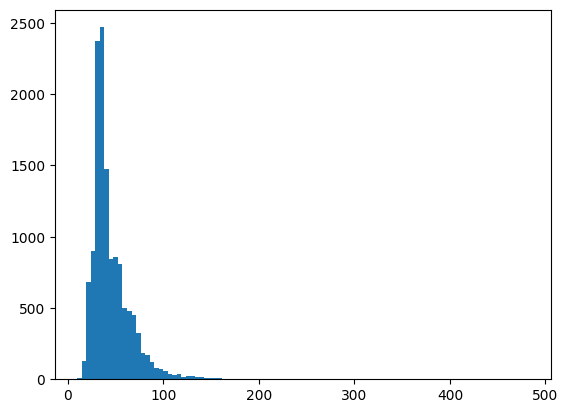

In [69]:
a = tokenized_splited_df["max_length_splited_tokens"]
from matplotlib import pyplot as plt
plt.hist(a, bins=100)
plt.show()

192     247
607     209
1109    202
1694    318
1884    404
2416    216
4205    251
5285    239
5309    201
5520    272
6782    482
Name: max_length_splited_tokens, dtype: int64

In [ ]:
# Compute the model performance metrics using `seqeval`
def compute_metrics(preds, all_labels):    
    try:
        #print("Compute metrics")
        predictions, labels = preds
        predictions = np.argmax(predictions, axis=2)
        # Include prediction Remove ignored index (special tokens)
        true_preds = []
        true_labels = []
        for pred, label in zip(predictions, labels):
            true_preds.append([all_labels[p] for p, l in zip(pred, label) if l != -100])
            true_labels.append([all_labels[l] for p, l in zip(pred, label) if l != -100])
    
        # Compute recall, precision and f1 score
        recall = recall_score(true_labels, true_preds)
        precision = precision_score(true_labels, true_preds)
        # Use modified f1 score to measure the performance
        f1_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)
        result = {'f1': f1_score,  
                  'recall': recall,
                  'precision': precision}
        print(f"result = {result}")
        return result
    except Exception as e: 
        print(e)

Model

In [ ]:
class ModelTrainer:
    def __init__(self, all_labels, label2id, id2label):
        self.all_labels = all_labels
        self.label2id = label2id
        self.id2label = id2label
        self.num_proc = 8
        self.learning_rate = 2e-5
        self.num_train_epochs = 3  # Number of epochs
        self.batch_size = 1  # Too large batch sizes lead to OOM
        self.fp16 = True if torch.cuda.is_available() else False
        self.model_path = Config.model_path
        self.output_dir = "/kaggle/output"
        self.save_path = f"/kaggle/deberta3base-truncation-false-{EXP}-{VER}"
        self.load_model()

    # Load the model
    def load_model(self):
        # Create the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        # Load tokenizer Config
        Config = DebertaV2Config.from_pretrained(self.model_path)
        # Increase context length using the max_position_embeddings parameter
        Config.update(
            {
                "num_labels": len(self.all_labels),
                "id2label": self.id2label,
                "label2id": self.label2id,
                "ignore_mismatched_sizes": True,
            }
        )
        # Create the model
        self.model = AutoModelForTokenClassification.from_pretrained(
            self.model_path, Config=Config
        )
        print("Complete loading pretrained LLM model")

    # Convert df to tokenized dataset
    def create_dataset(self, df: pd.DataFrame):
        ds = Dataset.from_dict(
            {
                "full_text": df["full_text"].tolist(),
                "document": df["document"].astype("string"),
                "tokens": df["tokens"].tolist(),
                "trailing_whitespace": df["trailing_whitespace"].tolist(),
                "provided_labels": df["labels"].tolist(),
            }
        )
        # Tokenize the dataset
        tokenized_ds = ds.map(
            tokenize,
            fn_kwargs={"tokenizer": self.tokenizer, "label2id": self.label2id},
            num_proc=self.num_proc,
        )
        return tokenized_ds

    # Train the model
    def train(self, train_df, valid_df):
        # Create training dataset
        training_ds = self.create_dataset(train_df)
        # Create valid dataset
        valid_ds = self.create_dataset(valid_df)
        # Data collator
        data_collator = DataCollatorForTokenClassification(
            self.tokenizer, pad_to_multiple_of=16
        )

        # Trainer cofiguration
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            fp16=self.fp16,  # # Change to False if using CPU only
            learning_rate=self.learning_rate,
            num_train_epochs=self.num_train_epochs,  # The total number of training epochs to run.
            per_device_train_batch_size=self.batch_size,  # batch size per device during training
            per_device_eval_batch_size=self.batch_size,  # batch size for evaluation
            gradient_accumulation_steps=2,
            report_to="none",
            evaluation_strategy="epoch",  # Evaluated at the end of epochs
            # eval_steps=1,
            do_eval=True,
            save_strategy="epoch",
            save_total_limit=2,  # Save the best and most recent checkpoints
            logging_steps=20,
            lr_scheduler_type="cosine",
            load_best_model_at_end=True,  # Load the best model at the end
            metric_for_best_model="f1",
            greater_is_better=True,
            warmup_ratio=0.1,  # number of warmup steps (0.1) for learning rate scheduler
            weight_decay=0.01,  # strength of weight decay
        )
        # Pass the modelTrainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=training_ds,
            eval_dataset=valid_ds,
            data_collator=data_collator,
            tokenizer=self.tokenizer,
            compute_metrics=partial(compute_metrics, all_labels=all_labels),
        )
        # Train the model
        trainer.train()
        # Save the model
        trainer.save_model(self.save_path)
        self.tokenizer.save_pretrained(self.save_path)
        print(f"Save the model to {self.save_path}")

Train

In [ ]:
# Training requires the GPUs and internet
TRAINING = True # True: Model Training, False: Model Inference
if TRAINING: 
    # Configuration class containing various model and training parameters
    trainer = ModelTrainer(all_labels, label2id, id2label)
    trainer.train(train_df, valid_df)

In [ ]:
# STRIDE=384
MAX_LENGTH = 1024
model_path = f"/kaggle/input/deberta3base-truncation-false-{EXP}-{VER}-small"
threshold = 0.99

In [ ]:
def tokenize(example, tokenizer):
    tokens = []
    token_map = []
    idx = 0
    for t, ws in zip(example["tokens"], example["trailing_whitespace"]):
        tokens.append(t)
        token_map.extend([idx]*len(t))
        if ws:
            tokens.append(" ")
            token_map.append(-1) 
        idx += 1
    # Does not truncate the text and concate all words together 
    # Do not need to have extra space as we have already include it in the previous tokenization
    tokenized = tokenizer("".join(tokens), return_offsets_mapping=True, truncation=False)
    return {**tokenized, "token_map": token_map}

Infer

In [ ]:
from scipy.special import softmax
from datasets import Dataset 
# Model Inferer
class ModelInfer:
    def __init__(self, all_labels, label2id, id2label):
        self.all_labels = all_labels
        self.label2id = label2id
        self.id2label = id2label
        self.model_path = model_path
        self.max_length = 1024
        self.infer_dir = "/kaggle/working/infer" # Model infer output 
        self.num_proc = 3 # 3 processors
        self.threshold = threshold # Threashold
        self.load_model()

    def load_model(self):
        # Create the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path) 
        # Create the model
        self.model = AutoModelForTokenClassification.from_pretrained(self.model_path)        
        # # Load the fine-tuned adapter layer on top of base model
        # self.model = self.model.to(DEVICE)
        print("Complete loading pretrained LLM model")

    def post_processing_preds(self, preds):
        preds_final = []
        preds_softmax = np.exp(preds) / np.sum(np.exp(preds), axis=2).reshape(preds.shape[0],
                                                                              preds.shape[1],
                                                                              1)
        # Get the maximal value as the final preds
        preds = preds.argmax(-1)
        preds_without_O = preds_softmax[:,:,:12].argmax(-1) # Prob of entity labels (like 'NAME_STUDENT')
        O_preds = preds_softmax[:,:,12] # Prob for 'O'
        print()
        # If preds for 'O' > 0.99, select preds of 'O'. Otherwise, select preds for entity labels.  
        preds_final = np.where(O_preds < self.threshold, preds_without_O, preds)
        return preds_final     
    
    def infer_preds(self, ds):
        # Tokenize the dataset using customized Tokenizer (the same as Training Tokenizer)
        tokenized_ds = ds.map(tokenize, fn_kwargs={"tokenizer": self.tokenizer}, num_proc=2)
        # Create data loader
        data_collator = DataCollatorForTokenClassification(self.tokenizer,
                                                           pad_to_multiple_of=16)
        # Arguments (infer only)
        args = TrainingArguments(output_dir=self.infer_dir,
                                 per_device_eval_batch_size=1, 
                                 report_to="none")
        # Create the trainer 
        trainer = Trainer(model=self.model, 
                          args=args, 
                          data_collator=data_collator, 
                          tokenizer=self.tokenizer)
        
        # predict for that split
        preds = trainer.predict(tokenized_ds).predictions
                
        # Clear the unused memory
        del self.model, data_collator, trainer, args 
        clear_memory()
        preds_final = self.post_processing_preds(preds)
        return preds_final, tokenized_ds

In [ ]:
test_data = pd.read_json("/kaggle/input/pii-detection-removal-from-educational-data/test.json")

test_ds = Dataset.from_dict({
    "full_text": test_data["full_text"].tolist(),
    "document": test_data["document"].tolist(),
    "tokens": test_data["tokens"].tolist(),
    "trailing_whitespace": test_data["trailing_whitespace"].tolist(),
})
print(f"Total number of test dataset {len(test_ds)}")
Config = json.load(open(Path(model_path) / "Config.json"))
id2label = Config["id2label"]
# Load the pretrained model and make the predictions
inferer = ModelInfer(all_labels, label2id, id2label)
preds_final, tokenized_ds = inferer.infer_preds(test_ds) 

Post Processing

In [ ]:
# Convert preds to a list of dictionaries
results = []
for p, token_map, offsets, tokens, doc in zip(preds_final,
                                              tokenized_ds["token_map"], 
                                              tokenized_ds["offset_mapping"],
                                              tokenized_ds["tokens"],
                                              tokenized_ds["document"]):
    for token_pred, (start_idx, end_idx) in zip(p, offsets):
        try:
            label_pred = id2label[str(token_pred)]
            if start_idx + end_idx == 0: 
                continue

            if token_map[start_idx] == -1:
                start_idx += 1
             # ignore "\n\n"
            while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
                start_idx += 1

            if start_idx >= len(token_map): 
                break

            token_id = token_map[start_idx]

            # ignore "O" predictions and whitespace preds
            if label_pred != "O" and token_id != -1:
                results.append({
                        "document": doc,
                        "token": token_id,
                        "label": label_pred,
                        "token_str": tokens[token_id]
                    })
                
        except Exception as e:
            print(f"Error {e}")
            print(f"token_map {len(token_map)} and {token_pred}  {start_idx} {end_idx}")
            sys.exit(-1)

In [ ]:
import re
from spacy.lang.en import English
nlp = English()

def find_span(target: list[str], document: list[str]) -> list[list[int]]:
    idx = 0
    spans = []
    span = []
    
    for i, token in enumerate(document):
        if token != target[idx]:
            idx = 0
            span = []
            continue
        span.append(i)
        
        idx += 1
        if idx == len(target):
            spans.append(span)
            span = []
            idx = 0
            continue
    
    return spans

email_regex = re.compile(r'[\w.+-]+@[\w-]+\.[\w.-]+')
phone_num_regex = re.compile(r"(\(\d{3}\)\d{3}\-\d{4}\w*|\d{3}\.\d{3}\.\d{4})\s")
emails = []
phone_nums = []

for _data in test_ds:
    # email
    for token_idx, token in enumerate(_data["tokens"]):
        if re.fullmatch(email_regex, token) is not None:
            emails.append(
                {"document": _data["document"], "token": token_idx, "label": "B-EMAIL", "token_str": token}
            )
    # phone number
    matches = phone_num_regex.findall(_data["full_text"])
    if not matches:
        continue
        
    for match in matches:
        target = [t.text for t in nlp.tokenizer(match)]
        matched_spans = find_span(target, _data["tokens"])
        
    for matched_span in matched_spans:
        for intermediate, token_idx in enumerate(matched_span):
            prefix = "I" if intermediate else "B"
            phone_nums.append(
                {"document": _data["document"], "token": token_idx, "label": f"{prefix}-PHONE_NUM", "token_str": _data["tokens"][token_idx]}
            )

results.extend(emails)
results.extend(phone_nums)

def remove_duplicates(df: pd.DataFrame):
    # Sort by the document and token
    df.sort_values(by=['document', 'token'])
    # Combine three columns 
    df['triplet'] = df[["document", "token", "label"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1) 
    # display(df)
    # Drop duplicated triplets and keep the first one as unique row
    df = df.drop_duplicates(subset=["triplet"], keep='first')
    # Regenerate 'row_id'
    df['row_id'] = list(range(len(df)))    
    df = df.reset_index(drop=True, inplace=False) 
    print("Remove duplicates")
#     display(df)
    return df

In [ ]:
test_df = pd.DataFrame(results)
test_df = remove_duplicates(test_df)
test_df = test_df[["row_id", "document", "token", "label"]]
# Create submission df
test_df.to_csv("submission.csv", index=False)
display(test_df)